In [ ]:
!pip install tensorflow
!pip install keras

In [ ]:
!unzip pickle.zip

Archive:  pickle.zip
   creating: pickle/
  inflating: pickle/.DS_Store        
  inflating: __MACOSX/pickle/._.DS_Store  
   creating: pickle/DHFR/
   creating: pickle/CRT/
   creating: pickle/DHPS/
  inflating: pickle/DHFR/trimmed_data_GB4.pkl  
  inflating: pickle/DHFR/trimmed_data_DD2.pkl  
  inflating: pickle/DHFR/trimmed_data_KH2.pkl  
  inflating: pickle/DHFR/trimmed_data_HB3.pkl  
  inflating: pickle/DHFR/trimmed_data_KH1.pkl  
  inflating: pickle/DHFR/trimmed_data_mix1.pkl  
  inflating: pickle/DHFR/trimmed_data_mix2.pkl  
  inflating: pickle/DHFR/trimmed_data_3D7.pkl  
  inflating: pickle/DHFR/trimmed_data_7G8.pkl  
  inflating: pickle/CRT/trimmed_data_DD2.pkl  
  inflating: pickle/CRT/trimmed_data_KH2.pkl  
  inflating: pickle/CRT/trimmed_data_KH1.pkl  
  inflating: pickle/CRT/trimmed_data_mix1.pkl  
  inflating: pickle/CRT/trimmed_data_mix2.pkl  
  inflating: pickle/CRT/trimmed_data_3D7.pkl  
  inflating: pickle/CRT/trimmed_data_7G8.pkl  
  inflating: pickle/DHPS/trimmed_da

In [ ]:
import tensorflow as tf
import numpy as np
from keras.datasets import cifar10
from keras.models import Sequential
from keras.layers.convolutional import Conv2D, MaxPooling2D
from keras.layers.core import Dense, Dropout, Activation, Flatten, Lambda
from keras.utils.np_utils import to_categorical
import VariantCalling as vc
import numpy as np
import matplotlib.pyplot as plt

In [ ]:
run_sequence = "CRT"
nb_epoch = 50
batch_size = 16
nb_filters = 48
nb_conv = 5
nb_pool = 3
nb_alignment = 2500
nb_channel = 2
nb_coverage = 100
nb_node = 128
train_loop = 4

# Sequence-specific Variables, too lazy to code the script everytime we train for a new sequence

In [ ]:
if run_sequence == "CRT":
    img_row, img_col = 101, 178
    nb_mutations = 3
    clone_names = ["3D7","7G8","DD2"]
elif run_sequence == "DHPS":
    img_row, img_col = 101, 642
    nb_mutations = 3
    clone_names = ["3D7","7G8","HB3"]
elif run_sequence == "DHFR":
    img_row, img_col = 101, 491
    nb_mutations = 4
    clone_names = ["3D7","7G8","DD2","HB3"]

In [ ]:
class SaveBestModel(tf.keras.callbacks.Callback):
    def __init__(self, save_best_metric='val_mse', this_max=False):
        self.save_best_metric = save_best_metric
        self.max = this_max
        if this_max:
            self.best = float('-inf')
        else:
            self.best = float('inf')

    def on_epoch_end(self, epoch, logs=None):
        metric_value = logs[self.save_best_metric]
        if self.max:
            if metric_value > self.best:
                self.best = metric_value
                self.best_weights = self.model.get_weights()

        else:
            if metric_value < self.best:
                self.best = metric_value
                self.best_weights= self.model.get_weights()

In [ ]:
"""
This section to test ratio_gen, which is wrapper for alignments
"""
dg = vc.VariantCallingData(file_name="clones.txt",gen_mode=2,pkl_sequence=run_sequence,pkl_clones=clone_names)
alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
prob_lists = (np.array(prob_lists)*100).tolist()


Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

In [ ]:
alignments = [dg._array_dup(i,101) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here we display an image and check the error rate

[15.32829672587231, 49.99513553969946, 34.67656773442822]


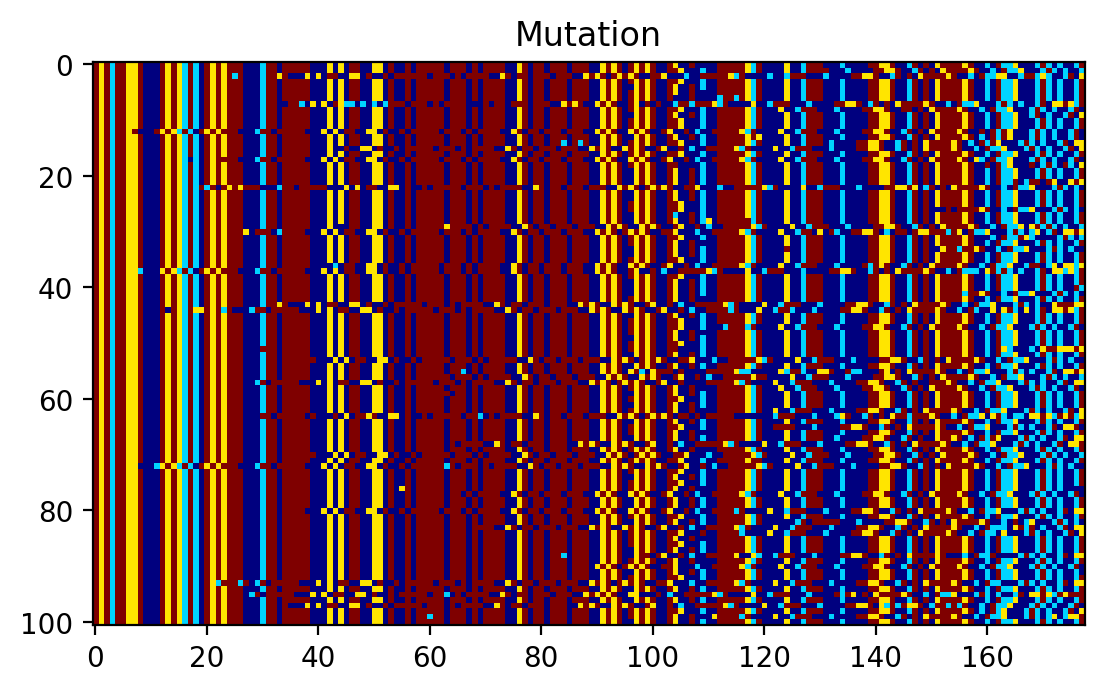

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][0],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 2, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 2, 101, 178)
(500, 2, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(nb_node))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 13s 12ms/step - loss: 109.8862 - mse: 312.3369 - val_loss: 109.8620 - val_mse: 328.5259
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 109.8743 - mse: 312.0756 - val_loss: 109.8455 - val_mse: 328.1581
Epoch 3/50
125/125 [==============================] - 1s 9ms/step - loss: 106.1027 - mse: 233.4614 - val_loss: 102.9918 - val_mse: 188.2535
Epoch 4/50
125/125 [==============================] - 1s 10ms/step - loss: 103.3572 - mse: 177.2122 - val_loss: 102.4508 - val_mse: 178.3426
Epoch 5/50
125/125 [==============================] - 1s 10ms/step - loss: 103.0548 - mse: 170.9815 - val_loss: 102.3881 - val_mse: 177.4857
Epoch 6/50
125/125 [==============================] - 1s 7ms/step - loss: 102.8749 - mse: 167.8158 - val_loss: 102.4575 - val_mse: 178.9929
Epoch 7/50
125/125 [==============================] - 1s 7ms/step - loss: 102.8619 - mse: 167.7443 - val_loss: 102.2668 - val_mse: 174.8968
Epoch 8/50
125/1

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_dup(i,101) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d (MaxPooling2D  (None, 6, 11, 48)        0         
 )                                                               
                                                                 
 activation (Activation)     (None, 6, 11, 48)         0         
                                                                 
 conv2d_1 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout (Dropout)           (None, 1, 1, 48)          0

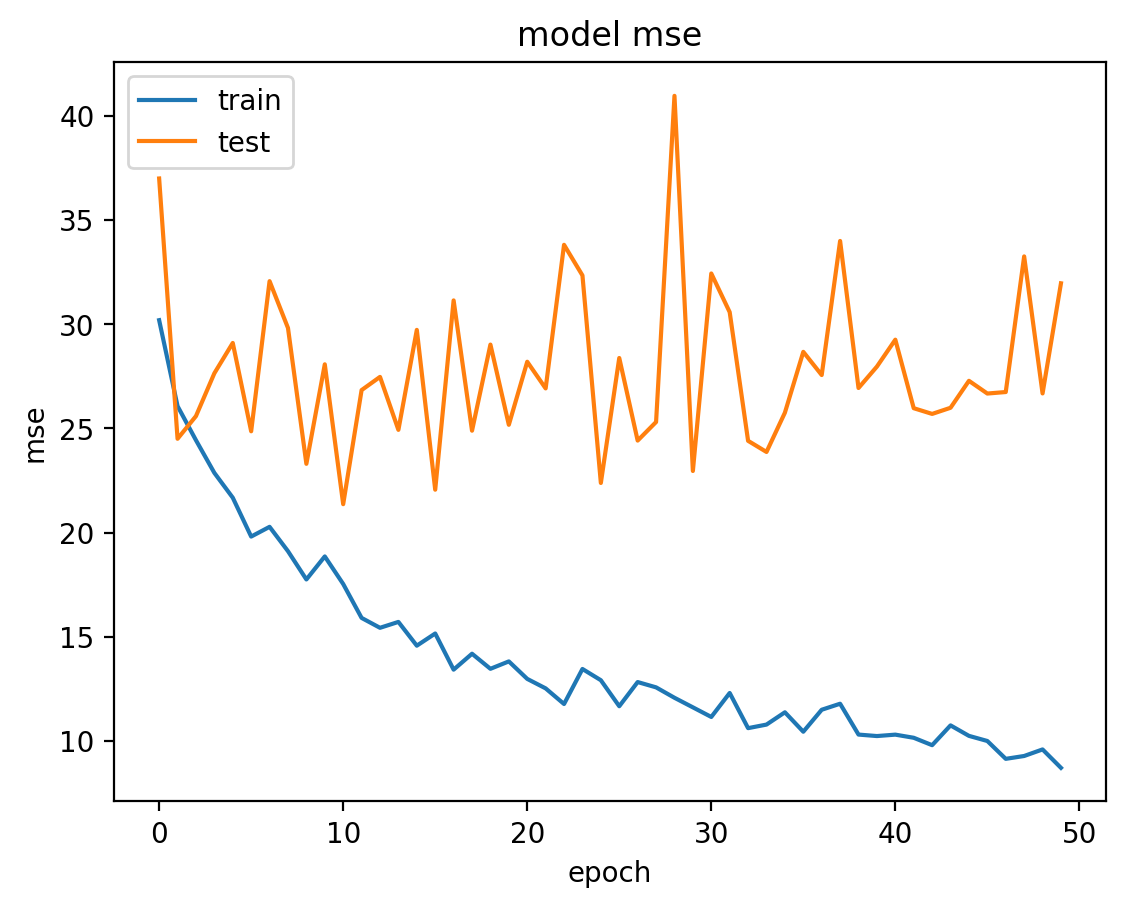

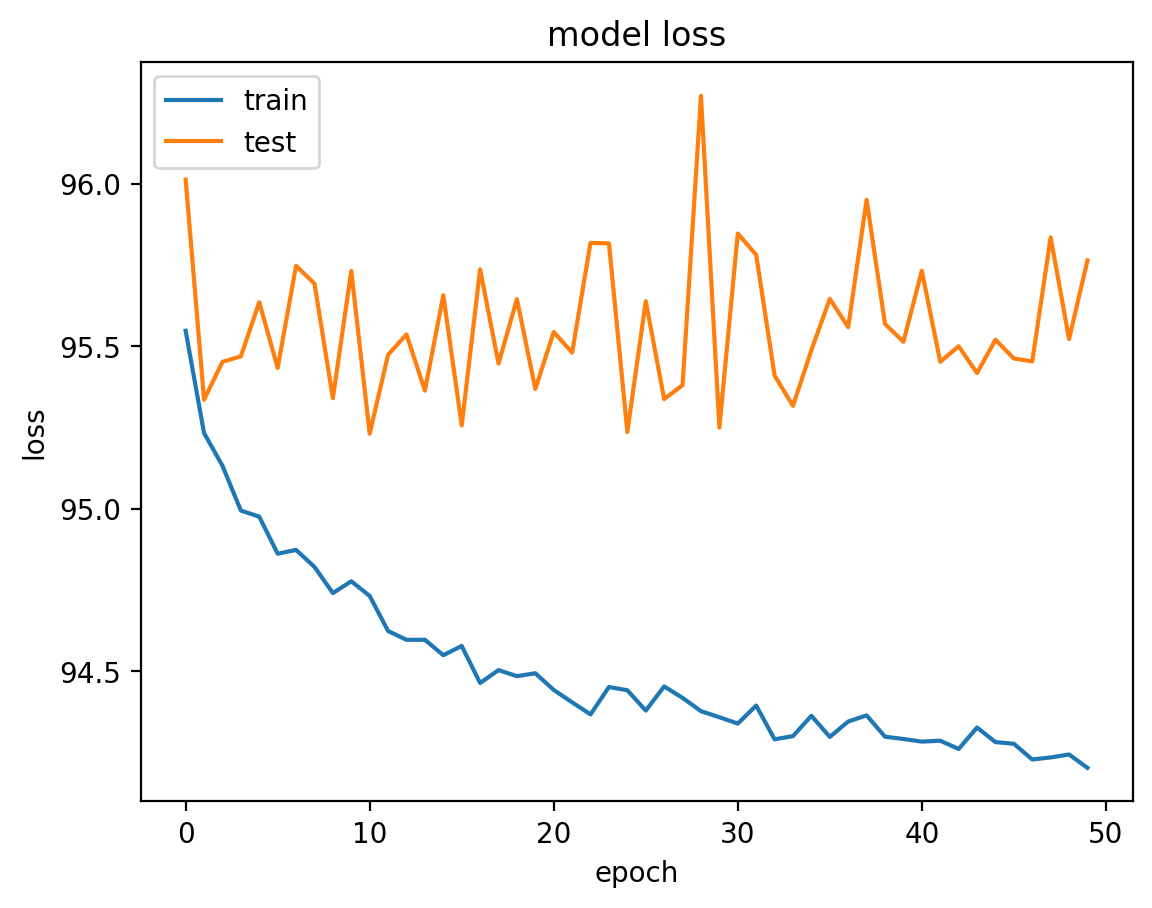

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('ref.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 10ms/step


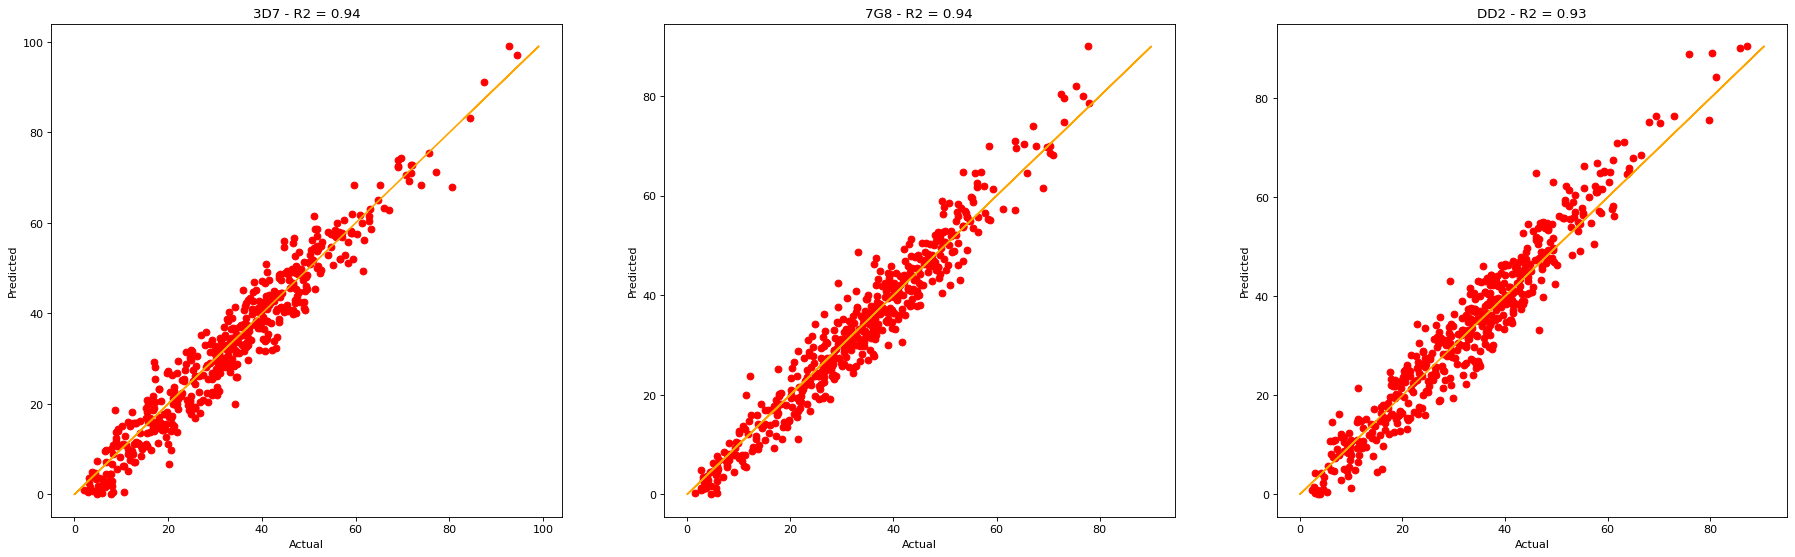

In [59]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict = pd.DataFrame(predict_array)
df_actual = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict.columns = clone_names
df_actual.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual[clone_names[i]], df_predict[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual[clone_names[i]], df_predict[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual[clone_names[i]])
    plt.plot(df_actual[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red')

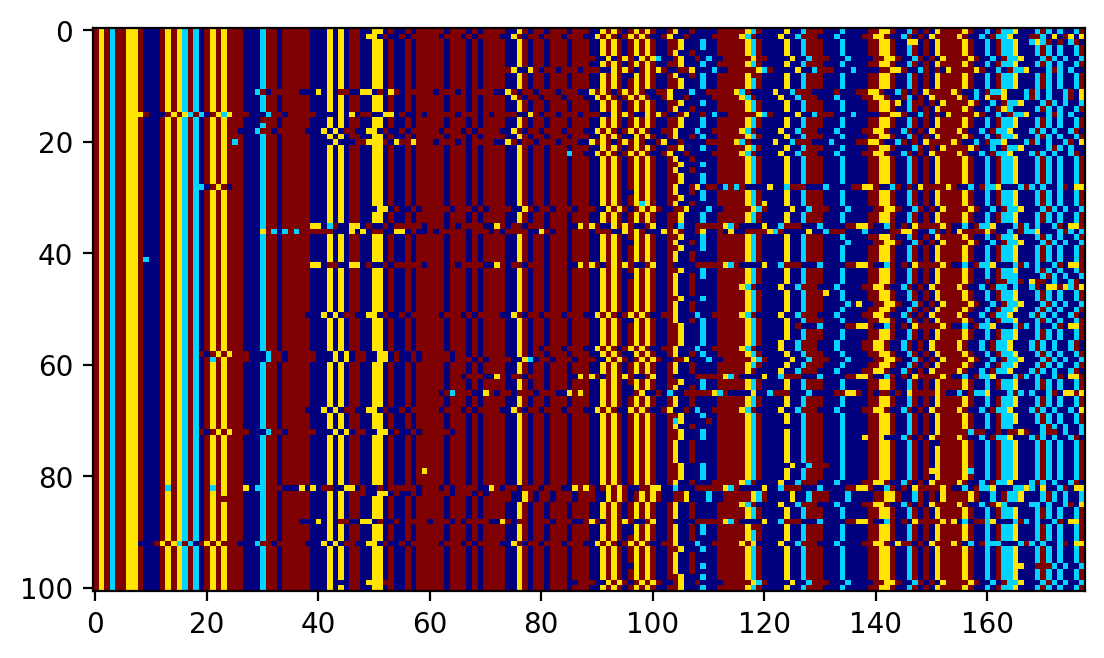

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.imshow(valid_alignments[0].reshape(nb_channel,img_row,img_col)[0],cmap='jet')

# Here we run the same training regime but replacing the second channel with a binary map

In [ ]:
alignments = [dg._array_binary_mask(i,101) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Display the binary map

[42.627177374308275, 29.97618887596899, 27.396633749722742]


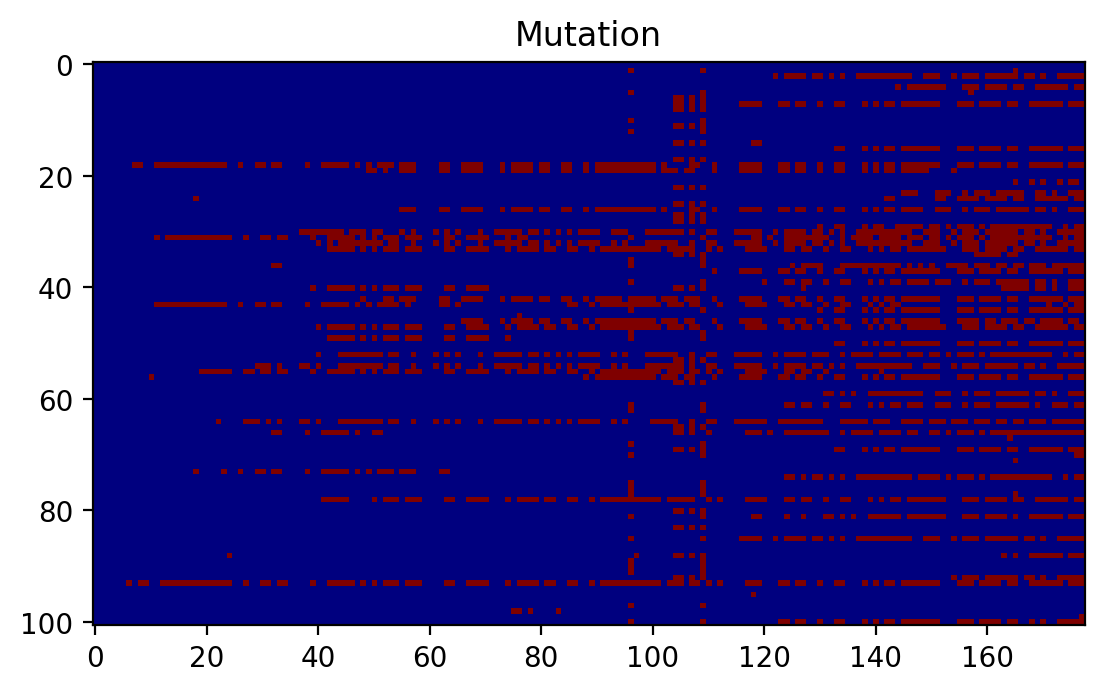

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 2, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 2, 101, 178)
(500, 2, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 4s 10ms/step - loss: 109.8619 - mse: 326.1313 - val_loss: 109.9008 - val_mse: 324.4747
Epoch 2/50
125/125 [==============================] - 1s 7ms/step - loss: 109.7656 - mse: 323.9896 - val_loss: 108.6037 - val_mse: 295.1371
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 100.9230 - mse: 131.7871 - val_loss: 97.6139 - val_mse: 64.4672
Epoch 4/50
125/125 [==============================] - 1s 7ms/step - loss: 98.2292 - mse: 79.8263 - val_loss: 97.3359 - val_mse: 58.1018
Epoch 5/50
125/125 [==============================] - 1s 8ms/step - loss: 97.1889 - mse: 60.2851 - val_loss: 96.6577 - val_mse: 45.2951
Epoch 6/50
125/125 [==============================] - 1s 9ms/step - loss: 96.6453 - mse: 50.3360 - val_loss: 96.4710 - val_mse: 41.4249
Epoch 7/50
125/125 [==============================] - 1s 10ms/step - loss: 96.1258 - mse: 41.3471 - val_loss: 96.3390 - val_mse: 41.3717
Epoch 8/50
125/125 [================

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_binary_mask(i,101) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_4 (Conv2D)           (None, 20, 35, 48)        2448      
                                                                 
 max_pooling2d_4 (MaxPooling  (None, 6, 11, 48)        0         
 2D)                                                             
                                                                 
 activation_6 (Activation)   (None, 6, 11, 48)         0         
                                                                 
 conv2d_5 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_5 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_3 (Dropout)         (None, 1, 1, 48)         

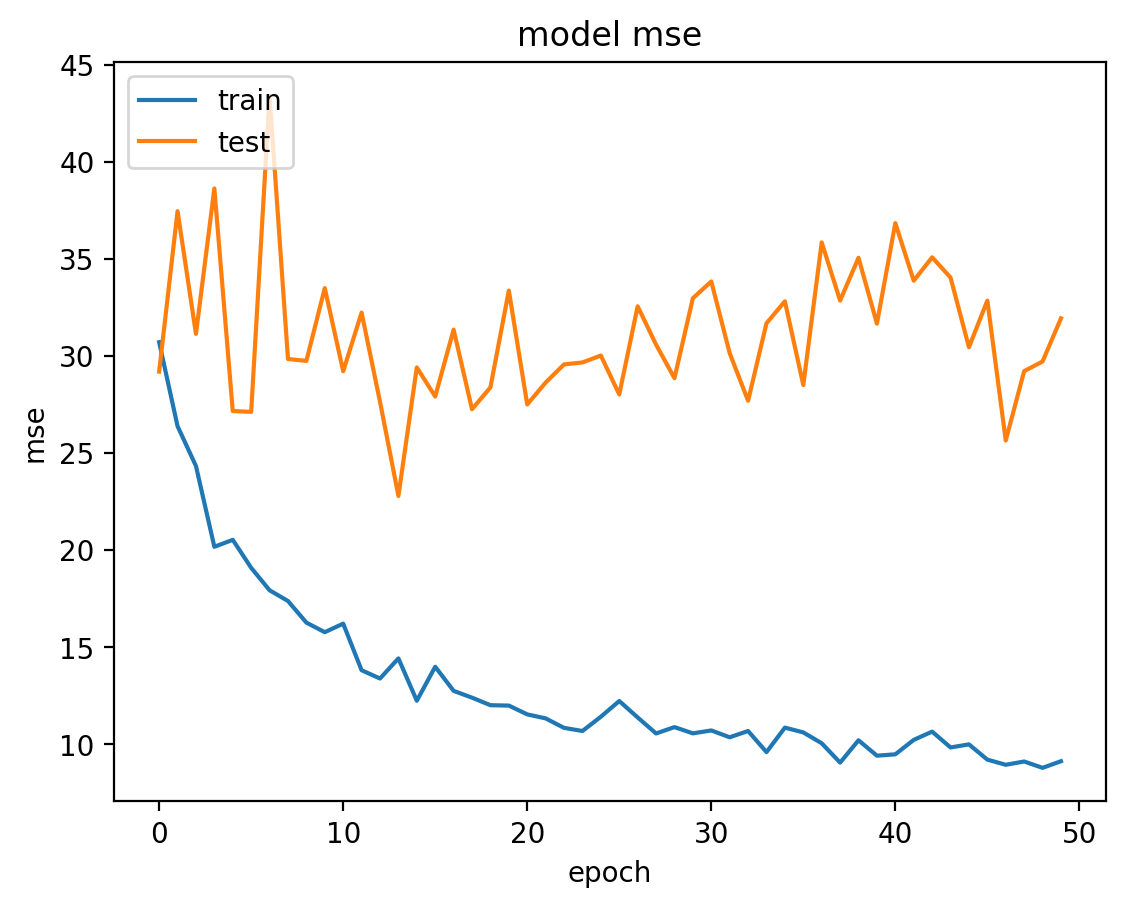

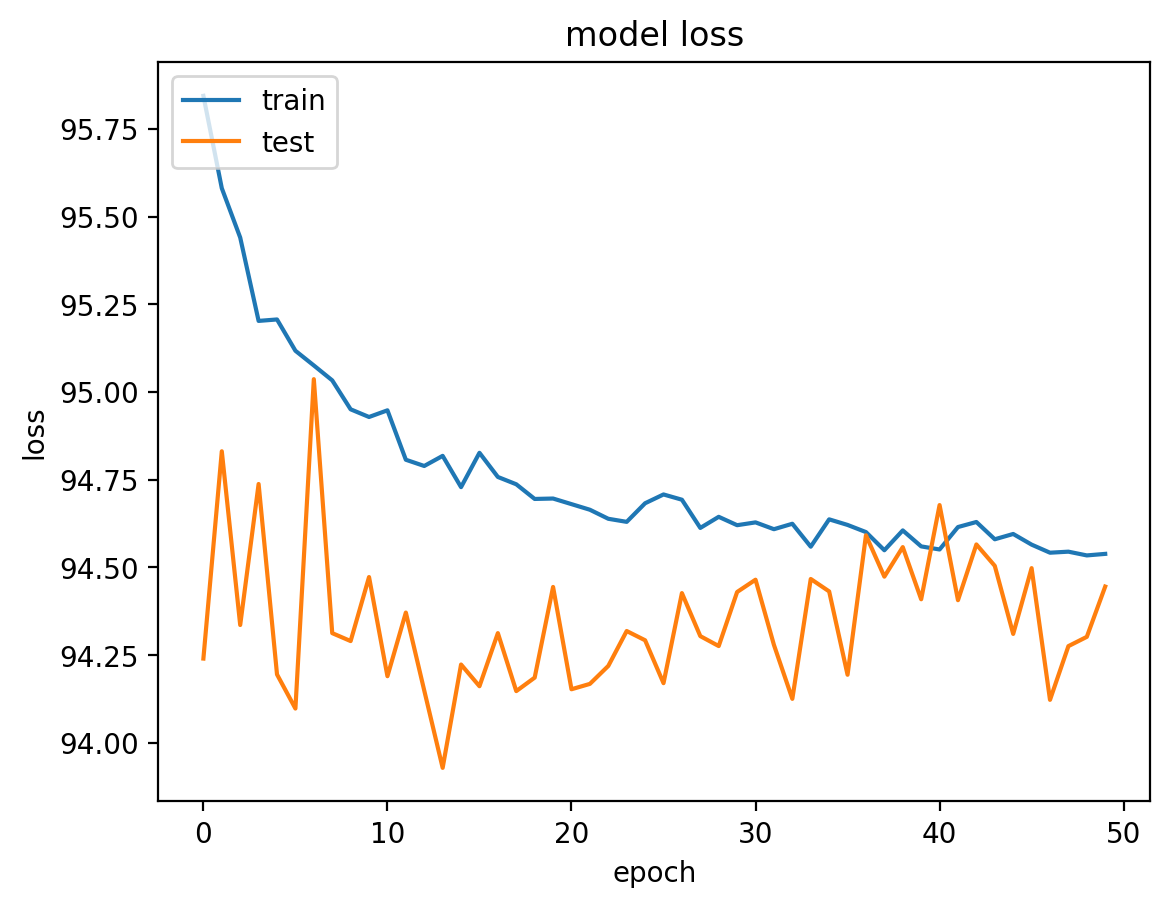

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bin_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 4ms/step


In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_binary_map = pd.DataFrame(predict_array)
df_actual_binary_map = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_binary_map.columns = clone_names
df_actual_binary_map.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)),fontsize=20)
    plt.ylabel('Predicted',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Actual',fontsize=20)
    plt.xticks(fontsize=20)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]],color='green')

# Here we run with both binary map and referecen matrix

In [ ]:
alignments = [dg._array_binary_mask(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here the number of channel will be updated to 3
nb_channel = 3

[25.98720364864854, 56.44345290793665, 17.569343443414805]


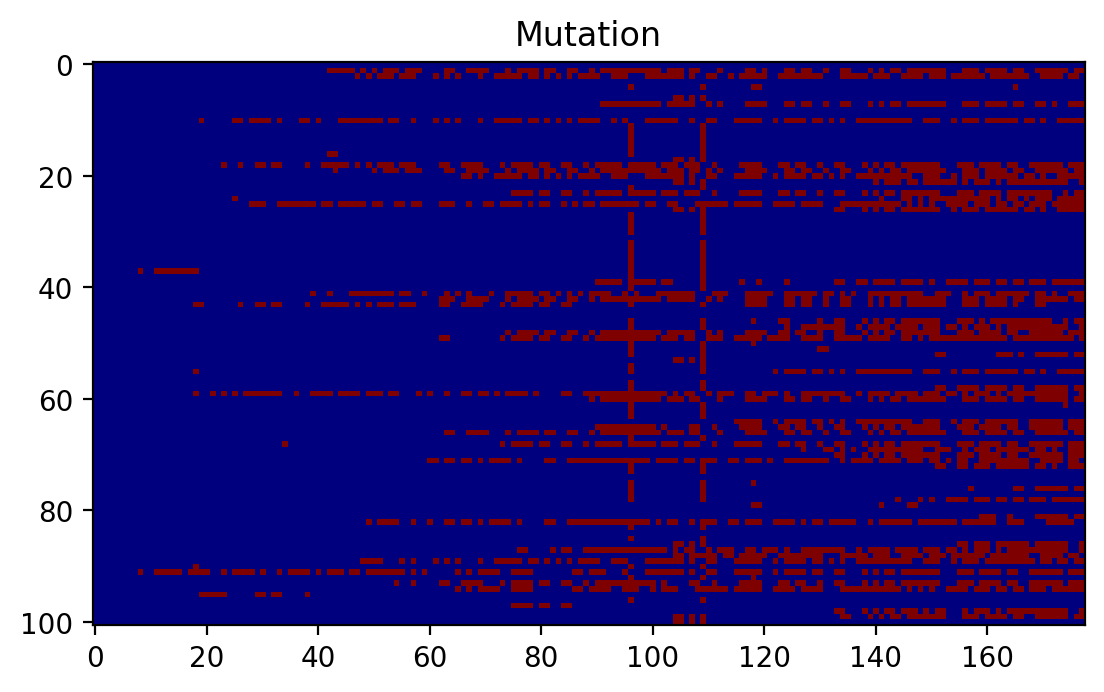

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1],cmap='jet')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

(2000, 3, 101, 178)
(2000, 3)


In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


(2000, 3, 101, 178)
(500, 3, 101, 178)


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Epoch 1/50
125/125 [==============================] - 4s 11ms/step - loss: 109.8864 - mse: 319.2268 - val_loss: 109.8954 - val_mse: 347.5667
Epoch 2/50
125/125 [==============================] - 1s 8ms/step - loss: 107.7638 - mse: 274.2947 - val_loss: 102.5804 - val_mse: 194.5466
Epoch 3/50
125/125 [==============================] - 1s 8ms/step - loss: 103.5805 - mse: 185.9813 - val_loss: 101.9884 - val_mse: 182.6657
Epoch 4/50
125/125 [==============================] - 1s 8ms/step - loss: 103.0880 - mse: 176.3508 - val_loss: 101.9348 - val_mse: 181.6308
Epoch 5/50
125/125 [==============================] - 1s 11ms/step - loss: 102.9521 - mse: 172.5440 - val_loss: 101.5562 - val_mse: 171.8745
Epoch 6/50
125/125 [==============================] - 1s 9ms/step - loss: 101.8734 - mse: 149.2581 - val_loss: 99.0130 - val_mse: 112.0559
Epoch 7/50
125/125 [==============================] - 1s 8ms/step - loss: 98.2437 - mse: 71.7768 - val_loss: 96.1442 - val_mse: 60.4896
Epoch 8/50
125/125 [===

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_binary_mask(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

Progress:  0.0% completed. 	Computing alignment 0 of 2500
Progress:  5.0% completed. 	Computing alignment 125 of 2500
Progress:  10.0% completed. 	Computing alignment 250 of 2500
Progress:  15.0% completed. 	Computing alignment 375 of 2500
Progress:  20.0% completed. 	Computing alignment 500 of 2500
Progress:  25.0% completed. 	Computing alignment 625 of 2500
Progress:  30.0% completed. 	Computing alignment 750 of 2500
Progress:  35.0% completed. 	Computing alignment 875 of 2500
Progress:  40.0% completed. 	Computing alignment 1000 of 2500
Progress:  45.0% completed. 	Computing alignment 1125 of 2500
Progress:  50.0% completed. 	Computing alignment 1250 of 2500
Progress:  55.0% completed. 	Computing alignment 1375 of 2500
Progress:  60.0% completed. 	Computing alignment 1500 of 2500
Progress:  65.0% completed. 	Computing alignment 1625 of 2500
Progress:  70.0% completed. 	Computing alignment 1750 of 2500
Progress:  75.0% completed. 	Computing alignment 1875 of 2500
Progress:  80.0% com

Model: "sequential_2"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d_8 (Conv2D)           (None, 20, 35, 48)        3648      
                                                                 
 max_pooling2d_8 (MaxPooling  (None, 6, 11, 48)        0         
 2D)                                                             
                                                                 
 activation_12 (Activation)  (None, 6, 11, 48)         0         
                                                                 
 conv2d_9 (Conv2D)           (None, 2, 3, 48)          57648     
                                                                 
 max_pooling2d_9 (MaxPooling  (None, 1, 1, 48)         0         
 2D)                                                             
                                                                 
 dropout_6 (Dropout)         (None, 1, 1, 48)         

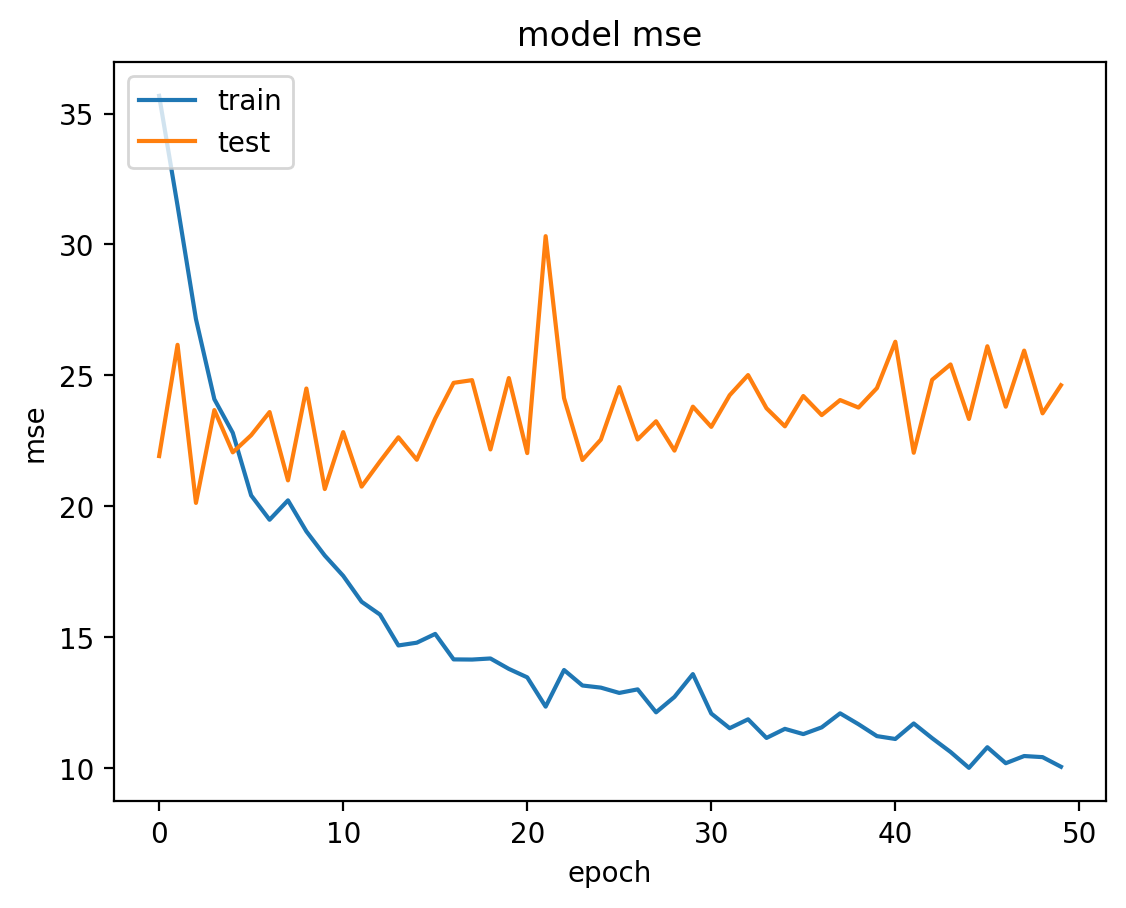

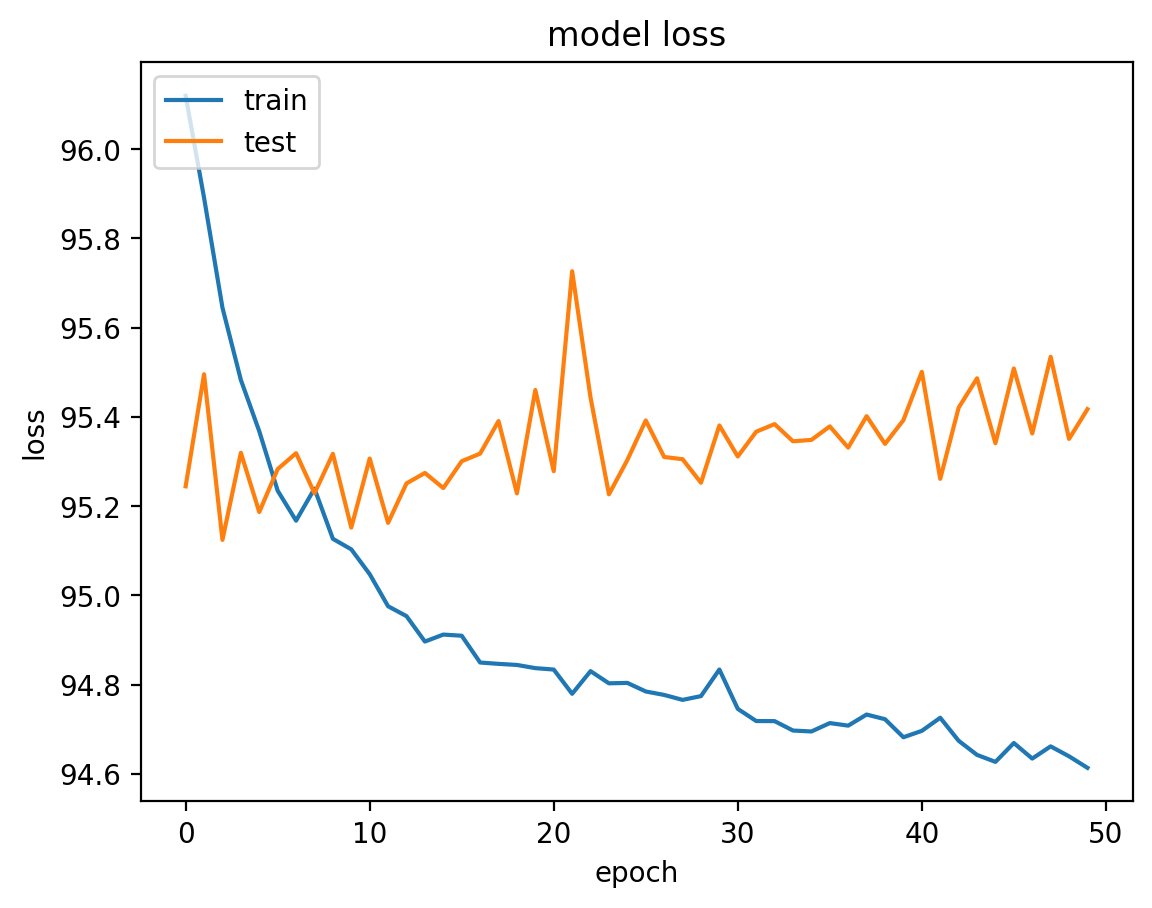

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bin_ref_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

16/16 [==============================] - 0s 7ms/step


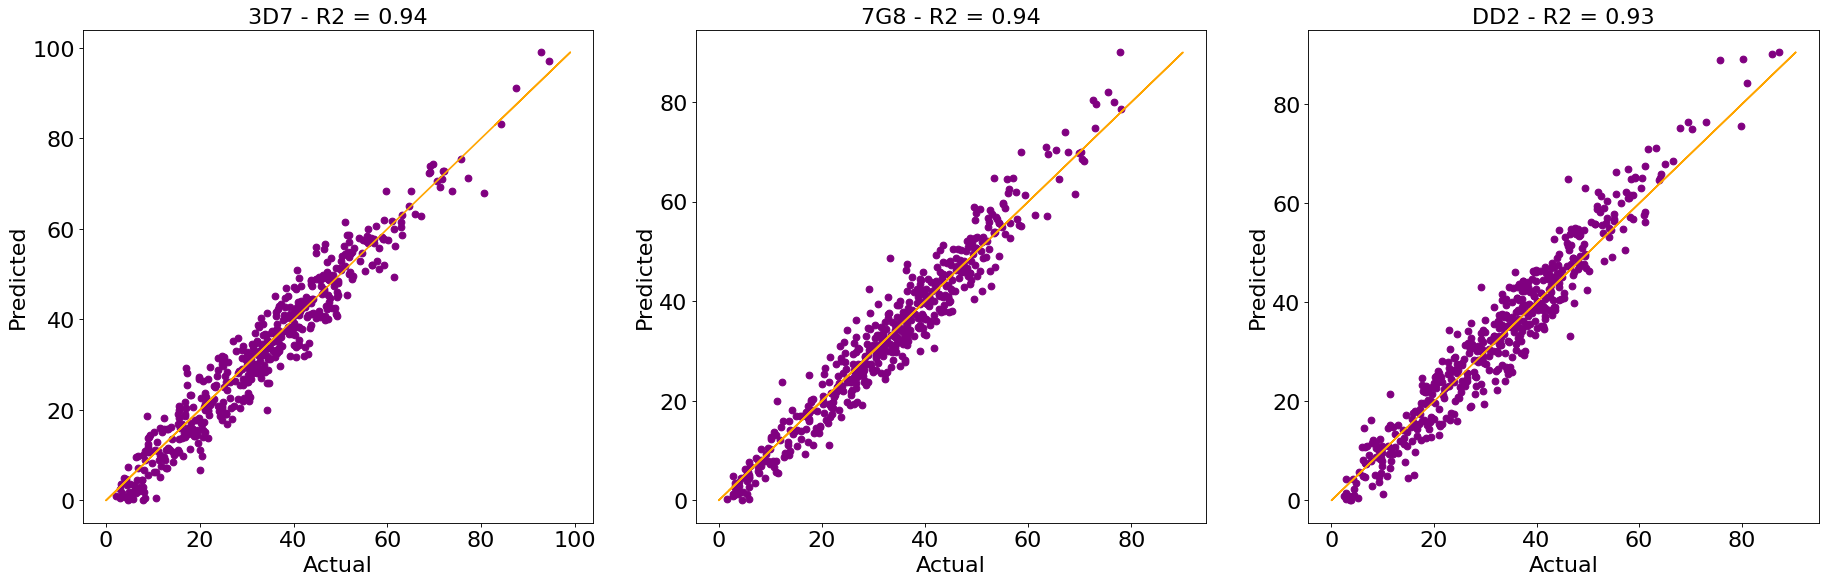

In [66]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_both = pd.DataFrame(predict_array)
df_actual_both = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_both.columns = clone_names
df_actual_both.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_both[clone_names[i]], df_predict_both[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_both[clone_names[i]])
    plt.plot(df_actual_both[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)),fontsize=20)
    plt.ylabel('Predicted',fontsize=20)
    plt.yticks(fontsize=20)
    plt.xlabel('Actual',fontsize=20)
    plt.xticks(fontsize=20)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='purple')

# Here we analyse the results and compare the MSE

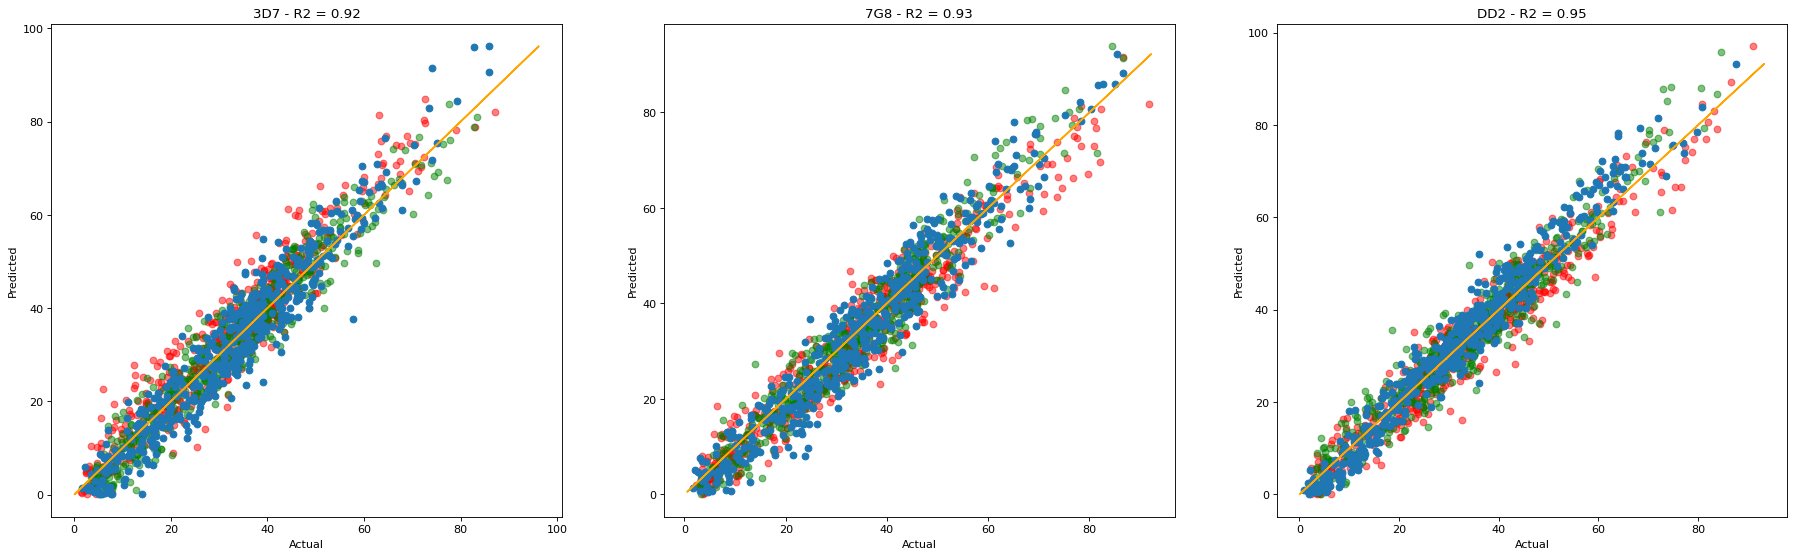

In [ ]:
plt.figure(figsize=(28, 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red',alpha=0.5)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='green',alpha=0.5)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]])

# Here we try separating into base-pair maps

In [ ]:
alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
alignments = dg.char_to_int(alignments)

# Here the number of channel will be updated to 3
nb_channel = 5

In [ ]:
plt.rcParams['figure.dpi'] = 200
#alignment_idx = mutation_types.index(mutation_index)
plt.title("Mutation")
plt.imshow(alignments[0][1], cmap='Greys_r')
#test_array = np.zeros((178, 100))
#plt.imshow(test_array, cmap='Greys')
print(prob_lists[0])

In [ ]:
rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
idxs = np.arange(alignments.shape[0])

rng.shuffle(idxs)

split_idx = int(alignments.shape[0]*0.8)
train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
#train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
print(train_alignments.shape)
print(train_prob_lists.shape)

In [ ]:
print(train_alignments.shape)
print(valid_alignments.shape)


train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)

train_alignments = train_alignments.astype('float32')
valid_alignments = valid_alignments.astype('float32')

train_alignments /= 3
valid_alignments /= 3


In [ ]:
model = Sequential()
model.add(Conv2D(nb_filters, nb_conv, nb_conv))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool)))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Activation('relu'))
model.add(Conv2D(nb_filters, nb_conv, nb_conv,padding="same"))
model.add(MaxPooling2D(pool_size = (nb_pool, nb_pool),padding="same"))
model.add(Flatten())
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
model.add(Dense(nb_node))
model.add(Dropout(0.1))
model.add(Activation('relu'))
#model.add(Dense(24))
#model.add(Dropout(0.2))
#model.add(Activation('relu'))
model.add(Dense(nb_mutations))
model.add(Activation('softmax'))
model.add(Lambda(lambda x: x * 100))
model.compile(metrics=['mse'],loss='categorical_crossentropy',optimizer='adam')

In [ ]:
save_best_model = SaveBestModel()
trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
model.set_weights(save_best_model.best_weights)

Here we run train loop to mitigate memory crunch

In [ ]:
for _ in range(0,train_loop):
    """
    This section to test ratio_gen, which is wrapper for alignments
    """
    alignments_raw, prob_lists = dg.simulate_clones(nb_alignment,nb_coverage,0.01,0.01)
    prob_lists = (np.array(prob_lists)*100).tolist()
    alignments = [dg._array_constituent_bp(i,101,True) for i in alignments_raw]
    alignments = dg.char_to_int(alignments)
    rng = np.random.default_rng(seed=42) # use a fixed random generator so runs are consistent
    idxs = np.arange(alignments.shape[0])
    rng.shuffle(idxs)
    split_idx = int(alignments.shape[0]*0.8)
    train_alignments, valid_alignments = alignments[idxs[:split_idx]], alignments[idxs[split_idx:]]
    train_prob_lists, valid_prob_lists = np.array(prob_lists)[idxs[:split_idx]], np.array(prob_lists)[idxs[split_idx:]]
    #train_mutation_types, valid_mutation_types = mutation_types[idxs[:split_idx]], mutation_types[idxs[split_idx:]]
    print(train_alignments.shape)
    print(train_prob_lists.shape)
    print(train_alignments.shape)
    print(valid_alignments.shape)
    train_alignments = train_alignments.reshape(train_alignments.shape[0], img_row, img_col, nb_channel)
    valid_alignments = valid_alignments.reshape(valid_alignments.shape[0], img_row, img_col, nb_channel)
    train_alignments = train_alignments.astype('float32')
    valid_alignments = valid_alignments.astype('float32')
    train_alignments /= 3
    valid_alignments /= 3
    trained_model = model.fit(train_alignments, train_prob_lists, batch_size = batch_size, epochs = nb_epoch,  verbose = 1, validation_data = (valid_alignments, valid_prob_lists),callbacks=[save_best_model])
    model.set_weights(save_best_model.best_weights)

In [ ]:
model.summary()
print(trained_model.history.keys())
# summarize history for accuracy
plt.plot(trained_model.history['mse'])
plt.plot(trained_model.history['val_mse'])
plt.title('model mse')
plt.ylabel('mse')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
# summarize history for loss
plt.plot(trained_model.history['loss'])
plt.plot(trained_model.history['val_loss'])
plt.title('model loss')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'test'], loc='upper left')
plt.show()
model.save('bp_map_map.h5')

In [ ]:
with open('output.csv', 'w') as file:
    predict_array = model.predict(valid_alignments).tolist()
    for i in range(0, len(valid_prob_lists)):
        file.write("\nPredicted\n")
        file.write(str(predict_array[i]))
        file.write("\nActual\n")
        file.write(str(valid_prob_lists[i]))

In [ ]:
# Data visualisation and performance evaluation
import pandas as pd
from scipy.stats import linregress
from sklearn.metrics import r2_score

df_predict_bp_channel = pd.DataFrame(predict_array)
df_actual_bp_channel = pd.DataFrame(valid_prob_lists)

# Setup the headers
df_predict_bp_channel.columns = clone_names
df_actual_bp_channel.columns = clone_names

plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]])
    (m_1, b_1) = np.polyfit(df_actual_bp_channel[clone_names[i]], df_predict_bp_channel[clone_names[i]], 1)
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_bp_channel[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict_bp_channel[clone_names[i]], df_actual_bp_channel[clone_names[i]])

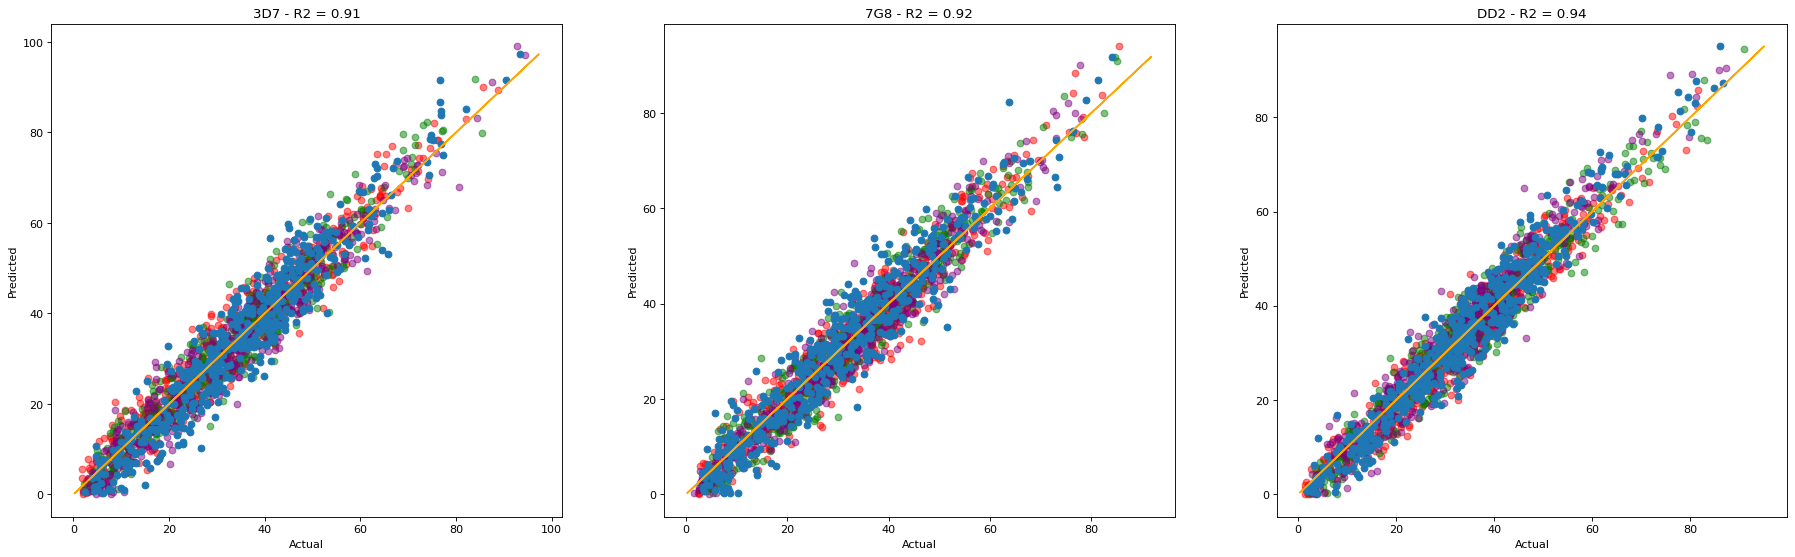

In [54]:
plt.figure(figsize=(4 + (8*len(clone_names)), 8), dpi=80)
for i in range(0,len(clone_names)):
    plt.subplot(1, len(clone_names), i+1)
    r2 = r2_score(df_actual_binary_map[clone_names[i]], df_predict_binary_map[clone_names[i]])
    yp_1 = np.polyval([1, 0], df_actual_binary_map[clone_names[i]])
    plt.plot(df_actual_binary_map[clone_names[i]], yp_1, color='orange')
    plt.title('{seq_name} - R2 = {r2_score}'.format(seq_name=clone_names[i],r2_score=round(r2,2)))
    plt.ylabel('Predicted')
    plt.xlabel('Actual')
    plt.scatter(df_predict[clone_names[i]], df_actual[clone_names[i]],color='red',alpha=0.5)
    plt.scatter(df_predict_both[clone_names[i]], df_actual_both[clone_names[i]],color='green',alpha=0.5)
    plt.scatter(df_predict_bp_channel[clone_names[i]], df_actual_bp_channel[clone_names[i]],color='purple',alpha=0.5)
    plt.scatter(df_predict_binary_map[clone_names[i]], df_actual_binary_map[clone_names[i]])


In [55]:
ax = 0

mse = []
mse_binary_map = []
mse_both = []
mse_bp_channel = []

for i in range(0,len(clone_names)):
    mse.append(((df_predict[clone_names[i]] - df_actual[clone_names[i]])**2).mean(axis=ax))
    mse_binary_map.append(((df_predict_binary_map[clone_names[i]] - df_actual_binary_map[clone_names[i]])**2).mean(axis=ax))
    mse_both.append(((df_predict_both[clone_names[i]] - df_actual_both[clone_names[i]])**2).mean(axis=ax))
    mse_bp_channel.append(((df_predict_bp_channel[clone_names[i]] - df_actual_bp_channel[clone_names[i]])**2).mean(axis=ax))

In [56]:
for i in range(0,len(clone_names)):
    print_string = str(mse[i]) + "\t" + str(mse_binary_map[i]) + "\t" + str(mse_both[i]) + "\t" + str(mse_bp_channel[i])
    print(print_string)

18.311375796850406	28.804745727145928	19.734844603548282	19.766327301517762
19.7873407603582	25.837189586597525	18.63724844769478	16.536638209401787
13.914045206728854	18.788610775577148	17.116972348480587	21.270710225983443


In [57]:
print(valid_prob_lists[1])
print(df_predict.iloc[1])
print(df_predict_binary_map.iloc[1])
print(df_predict_both.iloc[1])
print(df_predict_bp_channel.iloc[1])

[ 1.63756547 23.10910447 75.25333006]
3D7    49.790363
7G8     5.366890
DD2    44.842739
Name: 1, dtype: float64
3D7    40.676323
7G8    15.129232
DD2    44.194443
Name: 1, dtype: float64
3D7    30.525801
7G8    32.618629
DD2    36.855568
Name: 1, dtype: float64
3D7     3.385049
7G8    28.572735
DD2    68.042221
Name: 1, dtype: float64
